In [1]:
FN = '160313-fuse'

In [2]:
FN0 = '160306-patient'
FN1 = '160306-train.std'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import json
import os

/Users/udi/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
from utils import Dataset, params, Nt, Nv, Ns, temp_dir, out_dir, awscp
Na = Nt+Nv+Ns
ystd = np.array([ 43.24805568,  59.27725076]) # fix a bug
Nt, Nv, Ns

(500, 200, 440)

In [5]:
if out_dir.startswith('s3://'):
    lscmd = 'aws s3 ls ' + out_dir+'/'
else:
    lscmd = 'ls -1 ' + out_dir+'/'

In [6]:
awscp(FN0+'.pkl', verbose=True)
patient = pd.read_pickle(os.path.join(temp_dir,FN0+'.pkl'))

aws s3 cp s3://udikaggle/dsb.2/160306-patient.pkl /tmp/160306-patient.pkl
160306-patient.pkl bf4296c9f41fdc77679391bda051460333035a817d9144786bfaaf62


In [7]:
Ntraining = len(patient[['Systole','Diastole']].dropna())
assert Ntraining == Nt or Ntraining == Nt+Nv
Ntraining

700

In [8]:
Y = patient[['Systole','Diastole']].values.astype(float)
Y = Y[:Ntraining]
Y.shape,Y.min(axis=0),Y.mean(axis=0)

((700, 2), array([ 3.93,  9.35]), array([  71.13735714,  164.12514286]))

In [9]:
def yfix(yp):
    mask = np.where(yp[:,1] < yp[:,0])
    yp[mask,:] = yp[mask,::-1]
    yp = np.clip(yp,3,600)
    ypm = np.sqrt(yp[:,0]*yp[:,1])
    yp[:,0] = np.clip(yp[:,0],ypm*np.sqrt(0.1),ypm)
    yp[:,1] = np.clip(yp[:,1],ypm,ypm/np.sqrt(0.1))
    return yp

In [10]:
# each item in FNX has the following structure
# (<file name>,-1) = load file as is. If file contains "*" then look for latest iteration
# (<file name>,0) = look for last iteration
# (<file name>,<seed>) = add seed to file name and look for last iteration 
# (<file name>,(<seed>,(None,<split>)) = add seed and split and look for latest iteration
# (<file name>,(<seed>,(<iteration>,<split>)) = add seed itetation and split and load
# <file name> can be a tupple in which case the first element is the file name to read and the second is to label it

FNX = []
for seed in range(1000,1020):
    for isplit in range(3):
        FNX.append((FN1,(seed,(None,isplit)),False))

In [11]:
import cPickle as pickle
try:
    with open(os.path.join(temp_dir,FN+'.files.pkl'),'rb') as fp:
        files = pickle.load(fp)
    print "there are %d files already downloaded in %s"%(len(files), temp_dir)
except:
    files = []

In [12]:
def ffilter(res, pattern, itersplit):
    res = [r.split()[-1] for r in res]
    res = [f for f in res if f.find(pattern) >= 0]
    # filter wanted iteration and split
    if itersplit is not None and itersplit[0] is not None:
        res = [r for r in res if r.endswith('.iter-%d.%d.pkl'%itersplit)]
        res = sorted(res,key=lambda x: -int(x.split('.')[-3].split('-')[1]))
    if itersplit is not None and itersplit[0] is None:
        res = [r for r in res if r.endswith('.%d.pkl'%itersplit[1])]
        res = res[-1:]
    return res

In [13]:
import os.path
# files =[]
df = {}
df_count = {}
df_var = {}
df_var_count = {}
itests = {}
for fnseed in FNX:
    if len(fnseed) == 2:
        fn, seed = fnseed
        bug_fix = True
    else:
        fn, seed, bug_fix = fnseed
        
    if isinstance(seed,int):
        itersplit = None
    else:
        seed, itersplit = seed
        
    fn1 = fn
    if isinstance(fn, tuple):
        fn, fn1 = fn
        
    if seed >= 0:
        didls = False
        if seed:
            pattern = '%s.seed%d.yp.iter-'%(fn,seed)
        else:
            pattern = '%s.yp.iter-'%(fn)
        # default pattern in case pattern is not found
        pattern1 = '%s.yp.iter-'%(fn)
        # look for pattern in files we already know about
        res = ffilter(files, pattern, itersplit)
        if not res:
            res = ffilter(files, pattern1, itersplit)
            if res:
                print "Default",fn
        # if not found, look for pattern in S3
        if not res:
            didls = True
            fres = !{lscmd}
            res = ffilter(fres, pattern, itersplit)
            if not res:
                res = ffilter(fres, pattern1, itersplit)
                if res:
                    print "Default S3",fn
        if not res:
            print 'cant find',fnseed
#             !{lscmd} | grep {pattern}
            continue
        fname = res[0]
        if didls:
            print "S3",fname
        awscp(fname)
        with open(os.path.join(temp_dir, fname),'rb') as fp:
            yp_corrected, Y_itest, itest, yp_test = pickle.load(fp)
        itest = np.concatenate((itest,np.arange(Ntraining,Na)))
        yp = np.vstack((yp_corrected, yp_test))
    else:
        # load file directly
        res = !{lscmd} | grep {fn}
        res = sorted(res,key=lambda x: -int(x.split('.')[-3].split('-')[1]))
        if not res:
            print 'cant find',fnseed
            break
        fname = res[0]
        awscp(fname)
        if fname.endswith('.npy'):
            itest = np.arange(Na)
            yp = np.load(os.path.join(temp_dir, fname))
        else:
            assert fname.endswith('.pkl')
            with open(os.path.join(temp_dir, fname),'rb') as fp:
                yp_corrected, Y_itest, itest, yp_test = pickle.load(fp)
            itest = np.concatenate((itest,np.arange(Ntraining,Na)))
            yp = np.vstack((yp_corrected, yp_test))
    # make sure predictions make sense
    ypprb = yfix(yp[:,:2])
#     fld = '%s.%d'%(fn1,seed)
    fld = fname

    if fld not in df:
        df[fld] = np.zeros((Na,2))
        df_count[fld] = np.zeros(Na)
        if yp.shape[1] == 4:
            df_var[fld] = np.zeros((Na,2))
            df_var_count[fld] = np.zeros(Na)

    itests[fname] = itest
    df_count[fld][itest] += 1
    df[fld][itest,:] += ypprb
    if yp.shape[1] == 4:
        df_var_count[fld][itest] += 1
        if bug_fix:
            # /ystd is a BUG FIX in 160221-train-std-clip
            df_var[fld][itest,:] += yp[:,2:]*yp[:,2:]/ystd
        else:
            df_var[fld][itest,:] += yp[:,2:]*yp[:,2:]

S3 160306-train.std.seed1000.yp.iter-531.0.pkl
S3 160306-train.std.seed1000.yp.iter-350.1.pkl
S3 160306-train.std.seed1000.yp.iter-400.2.pkl
S3 160306-train.std.seed1001.yp.iter-494.0.pkl
S3 160306-train.std.seed1001.yp.iter-651.1.pkl
S3 160306-train.std.seed1001.yp.iter-234.2.pkl
S3 160306-train.std.seed1002.yp.iter-269.0.pkl
S3 160306-train.std.seed1002.yp.iter-352.1.pkl
S3 160306-train.std.seed1002.yp.iter-427.2.pkl
S3 160306-train.std.seed1003.yp.iter-381.0.pkl
S3 160306-train.std.seed1003.yp.iter-391.1.pkl
S3 160306-train.std.seed1003.yp.iter-368.2.pkl
S3 160306-train.std.seed1004.yp.iter-539.0.pkl
S3 160306-train.std.seed1004.yp.iter-456.1.pkl
S3 160306-train.std.seed1004.yp.iter-455.2.pkl
S3 160306-train.std.seed1005.yp.iter-433.0.pkl
S3 160306-train.std.seed1005.yp.iter-239.1.pkl
S3 160306-train.std.seed1005.yp.iter-558.2.pkl
S3 160306-train.std.seed1006.yp.iter-609.0.pkl
S3 160306-train.std.seed1006.yp.iter-571.1.pkl
S3 160306-train.std.seed1006.yp.iter-453.2.pkl
S3 160306-tra

In [14]:
fnames = df.keys()
len(fnames)

60

In [15]:
# save files stored in temp_dir to save time on re-run
with open(os.path.join(temp_dir,FN+'.files.pkl'),'wb') as fp:
    pickle.dump(fnames, fp, -1)

In [16]:
df0 = pd.DataFrame(dict((k,v[:,0]/df_count[k]) for k,v in df.items()),index=range(Na))
df1 = pd.DataFrame(dict((k,v[:,1]/df_count[k]) for k,v in df.items()),index=range(Na))
dfx = pd.concat((df0,df1),keys=('sys','dia')).swaplevel(0, 1, axis=0).sort_index(level=0)

In [17]:
df0 = pd.DataFrame(dict((k,v[:,0]/df_count[k]) for k,v in df_var.items()),index=range(Na))
df1 = pd.DataFrame(dict((k,v[:,1]/df_count[k]) for k,v in df_var.items()),index=range(Na))
dfx_var = pd.concat((df0,df1),keys=('sys','dia')).swaplevel(0, 1, axis=0).sort_index(level=0)

In [18]:
dfy = pd.concat((pd.DataFrame({'y':Y[:,0]}),pd.DataFrame({'y':Y[:,1]})),keys=('sys','dia')).swaplevel(0, 1, axis=0).sort_index(level=0)

In [19]:
def score(cols):
    return np.sqrt(np.mean((dfx[cols].mean(axis=1).values[:Ntraining*2] - dfy.values[:,0])**2))

remove= []
print score(fnames)             
for k in fnames:
    vals = [(score([c for j, c in enumerate(fnames) if j != i and j not in remove]), i)
            for i, _ in enumerate(fnames)]
    vals.sort(key=lambda x: x[0])
    val,j = vals[0]
    if val!=val:
        break
    if j in remove:
        break
    remove.append(j)
    print j,val, fnames[j]

20.0689327476
26 20.0120955609 160306-train.std.seed1007.yp.iter-389.1.pkl
54 19.9555424412 160306-train.std.seed1017.yp.iter-227.1.pkl
7 19.9072058806 160306-train.std.seed1018.yp.iter-137.2.pkl
52 19.8708928398 160306-train.std.seed1005.yp.iter-239.1.pkl
20 19.8351403289 160306-train.std.seed1000.yp.iter-400.2.pkl
58 19.7961550324 160306-train.std.seed1008.yp.iter-335.2.pkl
10 19.75388378 160306-train.std.seed1009.yp.iter-379.1.pkl
22 19.7100976829 160306-train.std.seed1010.yp.iter-399.1.pkl
57 19.6660704051 160306-train.std.seed1019.yp.iter-279.1.pkl
19 19.6187866308 160306-train.std.seed1001.yp.iter-651.1.pkl
49 19.577171423 160306-train.std.seed1014.yp.iter-397.2.pkl
48 19.5373425246 160306-train.std.seed1008.yp.iter-431.1.pkl
14 19.5044371154 160306-train.std.seed1017.yp.iter-586.0.pkl
18 19.4762441023 160306-train.std.seed1004.yp.iter-539.0.pkl
40 19.4526360396 160306-train.std.seed1012.yp.iter-516.0.pkl
34 19.4274555438 160306-train.std.seed1015.yp.iter-461.2.pkl
24 19.40177126

In [20]:
fnames_mean = [f for i, f in enumerate(fnames) if i not in remove]
fnames_mean

['160306-train.std.seed1013.yp.iter-530.1.pkl',
 '160306-train.std.seed1008.yp.iter-492.0.pkl',
 '160306-train.std.seed1018.yp.iter-653.1.pkl',
 '160306-train.std.seed1000.yp.iter-531.0.pkl',
 '160306-train.std.seed1010.yp.iter-501.0.pkl',
 '160306-train.std.seed1014.yp.iter-476.0.pkl',
 '160306-train.std.seed1007.yp.iter-287.0.pkl',
 '160306-train.std.seed1014.yp.iter-524.1.pkl',
 '160306-train.std.seed1012.yp.iter-427.1.pkl',
 '160306-train.std.seed1010.yp.iter-616.2.pkl',
 '160306-train.std.seed1016.yp.iter-471.0.pkl',
 '160306-train.std.seed1006.yp.iter-609.0.pkl',
 '160306-train.std.seed1019.yp.iter-289.0.pkl',
 '160306-train.std.seed1007.yp.iter-647.2.pkl']

In [21]:
y_mean = dfx[fnames_mean].mean(axis=1).values

In [22]:
y_mean = y_mean.reshape((-1,2))

In [23]:
fnames_var = dfx_var.columns
len(fnames_var),len(fnames)

(60, 60)

In [24]:
def loss(cols):
    err2 = np.square(dfx[cols].mean(axis=1).values[:Ntraining*2] - dfy.values[:,0]).reshape((-1,2))
    var = dfx_var[cols].mean(axis=1).values[:Ntraining*2].reshape((-1,2))
    loss = np.log(var) + err2/var
    return loss.mean()

remove= []
print score(fnames_var)             
for k in fnames_var:
    vals = [(loss([c for j, c in enumerate(fnames_var) if j != i and j not in remove]), i)
            for i, _ in enumerate(fnames_var)]
    vals.sort(key=lambda x: x[0])
    val,j = vals[0]
    if val!=val:
        break
    if j in remove:
        break
    remove.append(j)
    print j,val, fnames_var[j]

20.0689327476
54 6.48509832794 160306-train.std.seed1018.yp.iter-137.2.pkl
30 6.47781125446 160306-train.std.seed1010.yp.iter-399.1.pkl
51 6.47050172758 160306-train.std.seed1017.yp.iter-227.1.pkl
0 6.46395362075 160306-train.std.seed1000.yp.iter-350.1.pkl
3 6.45725791005 160306-train.std.seed1001.yp.iter-234.2.pkl
15 6.45136642217 160306-train.std.seed1005.yp.iter-239.1.pkl
22 6.44694985533 160306-train.std.seed1007.yp.iter-389.1.pkl
42 6.44262750716 160306-train.std.seed1014.yp.iter-397.2.pkl
6 6.43849577309 160306-train.std.seed1002.yp.iter-269.0.pkl
28 6.43433097799 160306-train.std.seed1009.yp.iter-576.2.pkl
49 6.43031782481 160306-train.std.seed1016.yp.iter-471.0.pkl
11 6.42649520971 160306-train.std.seed1003.yp.iter-391.1.pkl
34 6.42259242195 160306-train.std.seed1011.yp.iter-442.1.pkl
46 6.41879932717 160306-train.std.seed1015.yp.iter-461.2.pkl
36 6.4146564032 160306-train.std.seed1012.yp.iter-427.1.pkl
12 6.41041351011 160306-train.std.seed1004.yp.iter-455.2.pkl
24 6.406148054

In [25]:
fnames_var = [f for i, f in enumerate(fnames_var) if i not in remove]
fnames_var

['160306-train.std.seed1000.yp.iter-531.0.pkl',
 '160306-train.std.seed1001.yp.iter-651.1.pkl',
 '160306-train.std.seed1004.yp.iter-539.0.pkl',
 '160306-train.std.seed1006.yp.iter-571.1.pkl',
 '160306-train.std.seed1007.yp.iter-287.0.pkl',
 '160306-train.std.seed1007.yp.iter-647.2.pkl',
 '160306-train.std.seed1008.yp.iter-431.1.pkl',
 '160306-train.std.seed1010.yp.iter-501.0.pkl',
 '160306-train.std.seed1010.yp.iter-616.2.pkl',
 '160306-train.std.seed1012.yp.iter-578.2.pkl',
 '160306-train.std.seed1013.yp.iter-295.0.pkl',
 '160306-train.std.seed1014.yp.iter-524.1.pkl',
 '160306-train.std.seed1015.yp.iter-531.1.pkl',
 '160306-train.std.seed1016.yp.iter-657.1.pkl',
 '160306-train.std.seed1018.yp.iter-585.0.pkl',
 '160306-train.std.seed1018.yp.iter-653.1.pkl']

In [26]:
y_std = np.sqrt(dfx_var[fnames_var].mean(axis=1).values.reshape((-1,2)))

In [27]:
for p in [0,268,414,415,483]:
    print Y[p],y_mean[p]

[ 108.3  246.7] [  99.20565865  241.93897913]
[ 488.6  568.6] [ 355.2909373   490.02593913]
[  4.6  12.9] [  4.76894473  12.84499409]
[  88.4  157.6] [  85.39982702  152.98340747]
[ 200.3  277.9] [ 233.27389699  347.04982996]


[ 26  59  63  81 164 221 233 268 279 306 320 430 594 598 642]
[ 59 211 213 221 240 266 302 306 320 430 594 598 642]


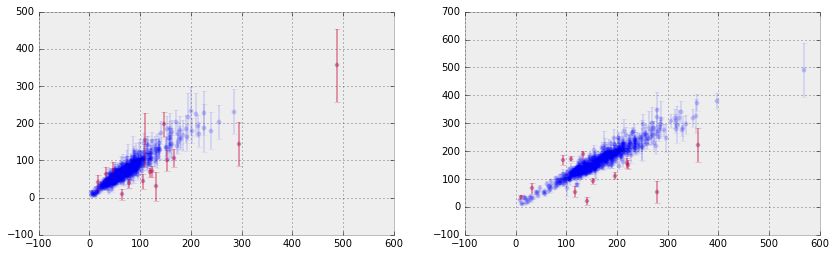

In [28]:
def plot_outliers(Y,y_mean,y_std,mask=None):
    plt.scatter(Y[:],y_mean[:Ntraining],alpha=0.1,color='b');
    plt.errorbar(Y[:],y_mean[:Ntraining], yerr=y_std[:Ntraining], fmt='.',alpha=0.1,color='b')
    if mask is None:
        mask = np.where(np.abs(Y[:]-y_mean[:Ntraining])/(Y[:]+100) > 0.2)[0]
        print mask
#     plt.scatter(Y[mask],y_mean[mask],alpha=0.3,color='r')
    plt.errorbar(Y[mask],y_mean[mask], yerr=y_std[mask], fmt='.',alpha=0.3,color='r')
        
plt.figure(figsize=(14,4))
plt.subplot(121)
plot_outliers(Y[:,0],y_mean[:,0],y_std[:,0])
plt.subplot(122)
plot_outliers(Y[:,1],y_mean[:,1],y_std[:,0]);

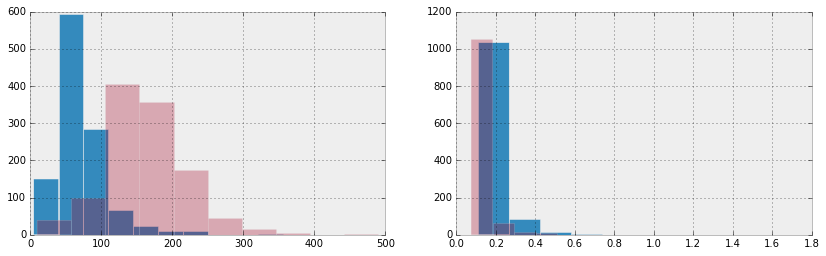

In [29]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.hist(y_mean[:,0])
plt.hist(y_mean[:,1],alpha=0.3);
plt.subplot(122)
plt.hist(y_std[:,0]/y_mean[:,0])
plt.hist(y_std[:,1]/y_mean[:,1],alpha=0.3);

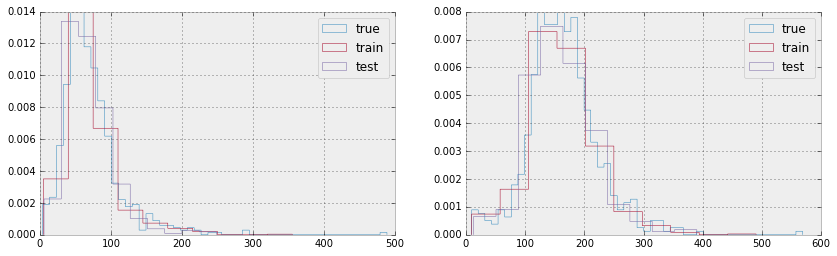

In [30]:
plt.figure(figsize=(14,4))
for m in range(2):
    plt.subplot(1,2,1+m)
    plt.hist(Y[:Ntraining,m],bins=50,histtype='step',normed=True,label='true')
    plt.hist(y_mean[:Ntraining,m],histtype='step',normed=True,label='train')
    plt.hist(y_mean[Ntraining:,m],histtype='step',normed=True,label='test');
    plt.legend()

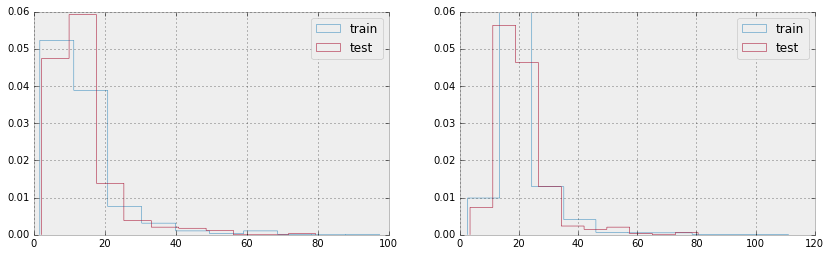

In [31]:
plt.figure(figsize=(14,4))
for m in range(2):
    plt.subplot(1,2,1+m)
    plt.hist(y_std[:Ntraining,m],histtype='step',normed=True,label='train')
    plt.hist(y_std[Ntraining:,m],histtype='step',normed=True,label='test');
    plt.legend()

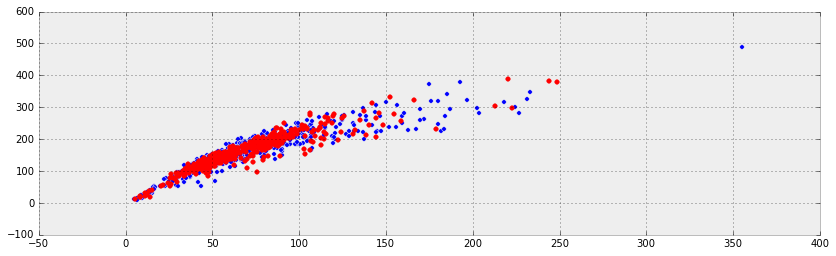

In [32]:
plt.figure(figsize=(14,4))
plt.scatter(y_mean[:Ntraining,0],y_mean[:Ntraining,1]);
plt.scatter(y_mean[Ntraining:,0],y_mean[Ntraining:,1],color='r');

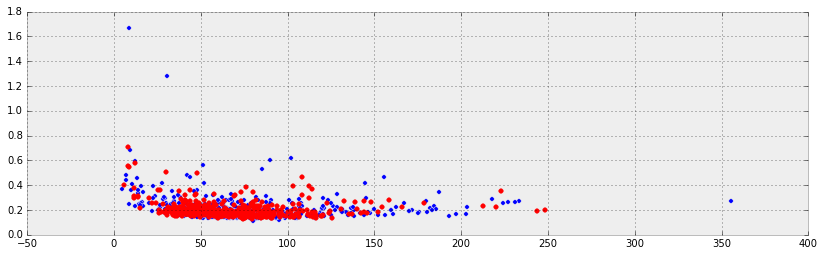

In [33]:
plt.figure(figsize=(14,4))
plt.scatter(y_mean[:Ntraining,0],y_std[:Ntraining,0]/y_mean[:Ntraining,0]);
plt.scatter(y_mean[Ntraining:,0],y_std[Ntraining:,0]/y_mean[Ntraining:,0],color='r');

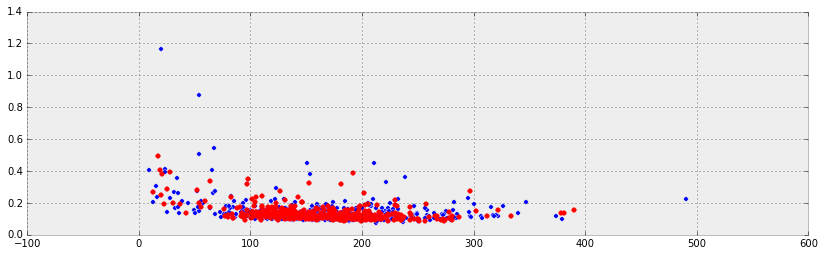

In [34]:
plt.figure(figsize=(14,4))
plt.scatter(y_mean[:Ntraining,1],y_std[:Ntraining,1]/y_mean[:Ntraining,1]);
plt.scatter(y_mean[Ntraining:,1],y_std[Ntraining:,1]/y_mean[Ntraining:,1],color='r');

(7.054057296638141, -0.10475041352964322, 0.78303011077196083)
(5.2574032279106149, -0.0092558152107782531, 0.71269271221966024)


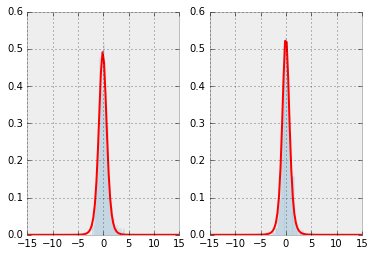

In [35]:
import scipy.stats

def myplt(err,fit=scipy.stats.t):
#     err -= err.mean()
    param = fit.fit(err) # distribution fitting

    # now, param[0] and param[1] are the mean and 
    # the standard deviation of the fitted distribution
    x = np.linspace(-15,15,100)
    # fitted distribution
    pdf_fitted = fit.pdf(x,df=param[0],loc=param[1],scale=param[2])
    plt.plot(x,pdf_fitted,'r-')
    plt.hist(err,normed=1,alpha=.3,bins=40)
    return param
betagamma=[]
for m in range(2):
    plt.subplot(121+m)
    res = myplt(((Y[:,m]-y_mean[:Ntraining,m])/y_std[:Ntraining,m]))
    print res
    betagamma.append(res[1])

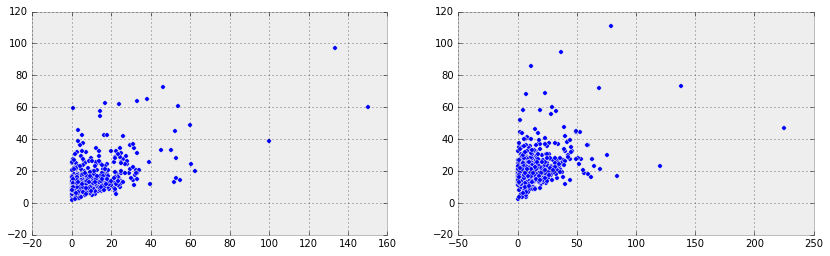

In [36]:
plt.figure(figsize=(14,4))
plt.subplot(121)
m=0
plt.scatter(np.clip(np.abs(Y[:,m]-y_mean[:Ntraining,m]),0,400),y_std[:Ntraining,m]);
plt.subplot(122)
m=1
plt.scatter(np.clip(np.abs(Y[:,m]-y_mean[:Ntraining,m]),0,400),y_std[:Ntraining,m]);

# plt.scatter(y_mean[Ntraining:,1],y_std[Ntraining:,1]/y_mean[Ntraining:,1],color='r');

In [37]:
np.where(y_std < 0),np.where(y_mean < 0)

((array([], dtype=int64), array([], dtype=int64)),
 (array([], dtype=int64), array([], dtype=int64)))

# Patient

In [38]:
times = ['meanmeanTriggerTime_sax','stdmeanTriggerTime_sax']
age = patient.PatientAge_sax.values
logage = np.log(age)
sex = patient.PatientSex_sax.values
Xaux = np.array([sex,np.log(age)]+[patient[t].values for t in times]).T

In [39]:
Xaux.shape

(1140, 4)

In [40]:
from sklearn.base import BaseEstimator
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

class Ridge(BaseEstimator):
    def __init__(self, alpha=72, nrm=True, naux=2):
        self.alpha = alpha
        self.nrm = nrm
        self.naux = naux
        
    def fit(self,X,y):
        self.lrs = []
        for measure in range(2):
            lr = linear_model.Ridge(alpha = self.alpha)
            if self.nrm:
                clf = Pipeline([('nrm',StandardScaler()),('lr',lr)])
            else:
                clf = lr
            clf.fit(X[:,:self.naux],y[:,measure])
            self.lrs.append(clf)

    def predict(self,X):
        lrs_predict = []
        for measure in range(2):
            lr_predict = self.lrs[measure].predict(X[:,:self.naux])
            lrs_predict.append(lr_predict)
        lrs_predict = np.array(lrs_predict).T
        return lrs_predict
    
    def score(self, X, y):
        return -np.sqrt(np.mean(np.square(y - self.predict(X)),axis=0)).mean()

In [41]:
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
clfg = GridSearchCV(Ridge(),param_grid={'alpha':np.logspace(1,1.5,8),'naux':[1,2,3,4]},n_jobs=-1,cv=10) #,verbose=1000)
clfg.fit(Xaux[:Ntraining,:],Y)
clfg.best_params_,-clfg.best_score_

({'alpha': 31.622776601683793, 'naux': 4}, 43.863959729193517)

In [42]:
Yaux = np.clip(clfg.predict(Xaux),1,600)

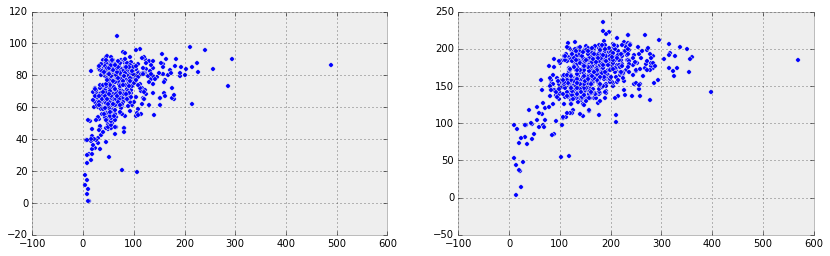

In [43]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.scatter(Y[:,0],Yaux[:Ntraining,0])
plt.subplot(122)
plt.scatter(Y[:,1],Yaux[:Ntraining,1])

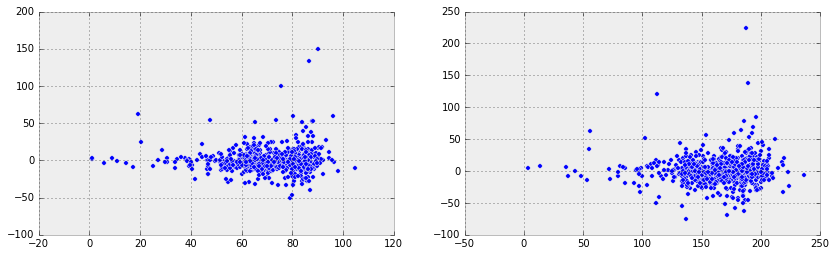

In [44]:
plt.figure(figsize=(14,4))
for m in range(2):
    plt.subplot(121+m)
    plt.scatter(Yaux[:Ntraining,m],(Y[:,m]-y_mean[:Ntraining,m]))

In [45]:
x = np.hstack((y_mean[:Ntraining,:1],Yaux[:Ntraining,:1]))
x.shape

(700, 2)

In [46]:
import statsmodels.api as sm
mymodel = sm.OLS(Y[:,0],x,'y',['ym','aux']).fit()

In [47]:
mymodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     4320.
Date:                Sun, 13 Mar 2016   Prob (F-statistic):          3.37e-301
Time:                        11:26:55   Log-Likelihood:                -2920.1
No. Observations:                 700   AIC:                             5844.
Df Residuals:                     698   BIC:                             5853.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             1.0552      0.017     60.418      0.000         1.021     1.090
x2            -0.0528      0.019     -2.738      0.006        -0.091    -0.015
==============================================================================
Omnibus:                      449.287   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11019.450
Skew:                           2.444   Prob(JB):                         0.00
Kurtosis:                      21.813   Cond. No.                         4.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## pack data

In [48]:
Yaux.shape

(1140, 2)

In [49]:
X = np.hstack((y_mean, y_std, Yaux))
NF = X.shape[1] # stat of auxiliary data
X.shape,NF

((1140, 6), 6)

In [50]:
Xtrain = X[:Ntraining]
Ytrain = Y[:Ntraining]
Xtrain.shape, Ytrain.shape

((700, 6), (700, 2))

# Model

In [51]:
def line_score(x,v):
    scr = (x - ((np.arange(600) - v) >= 0))
    return (scr*scr).mean()

import itertools
def score(y_true, y_pred):
    scores = []
    for yt, yp in itertools.izip(y_true, y_pred):
        scores.append(line_score(yp[0], yt[0]))
        scores.append(line_score(yp[1], yt[1]))
    return np.mean(scores)

In [52]:
from sklearn.base import BaseEstimator
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

## Student model

In [53]:
class Student(BaseEstimator):
    M = 600
    domain = np.arange(M)
    
    def __init__(self, beta=1., gamma=1., delta=7):
        self.beta = beta
        self.gamma = gamma
        self.delta=delta
        
    def fit(self,X,y):
        return self
    
    def predict_llk(self,X):
        N = len(X)
        domain = np.tile(self.domain,N).reshape((N,self.M))
        y = np.zeros((N,2,self.M))
        stdscale = [self.beta, self.gamma]
        for i in range(N):
            for m in range(2):
                y[i,m,:] = scipy.stats.t.logpdf((self.domain - X[i,m])/(stdscale[m]*X[i,m+2]), # /np.sqrt(X[i,4])
                                    df=self.delta)
        y = y - y.max(axis=2,keepdims=True)
        return y
    
    def predict(self,X):
        y = self.predict_llk(X)
        y = np.exp(y)
        y /= y.sum(axis=2,keepdims=True)
        y = y.cumsum(axis=2)
        return y
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return 1.-score(y, y_pred)

In [54]:
1.-Student().score(Xtrain,Ytrain)

0.014616891149281996

In [55]:
# clfg = GridSearchCV(Student(),param_grid={'beta':[0.83684210526315783], # np.linspace(0.7,0.9,20),
#                                           'gamma':[0.77368421052631575], #np.linspace(0.7,0.9,20),
#                                           'delta':np.linspace(10,100,20)},n_jobs=-1,cv=10)
# clfg.fit(Xtrain,Ytrain)
# clfg.best_params_,1.-clfg.best_score_

## Normal model

In [56]:
class Normal(BaseEstimator):
    M = 600
    domain = np.arange(M)
    
    def __init__(self, beta=0.8368421, gamma=0.773684210, aux=-0.086):
        self.beta = beta
        self.gamma = gamma
        self.aux = aux
        
    def fit(self,X,y):
        return self
    
    def predict_llk(self,X):
        N = len(X)
        domain = np.tile(self.domain,N).reshape((N,self.M))
        y = np.zeros((N,2,self.M))
        stdscale = [self.beta, self.gamma]
        for m in range(2):
            std = stdscale[m]*X[:,m+2,None] + self.aux*np.sqrt(X[:,m+4,None])# *np.sqrt(X[:,4,None])
            y[:,m,:] = -(domain - X[:,m,None])**2/(2.*std**2)
        y = y - y.max(axis=2,keepdims=True)
        return y
    
    def predict(self,X):
        y = self.predict_llk(X)
        y = np.exp(y)
        y /= y.sum(axis=2,keepdims=True)
        y = y.cumsum(axis=2)
        return y
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return 1.-score(y, y_pred)

In [57]:
1.-Normal(aux=0).score(Xtrain,Ytrain)

0.0143392565007745

In [58]:
def objective(args):
    clf = Normal(**args)
    return 1.-clf.score(Xtrain,Ytrain)

In [59]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
best = fmin(objective,
    space={
        'beta':hp.loguniform('beta', -1, 0),
        'gamma':hp.loguniform('gamma', -1, 0),
        'aux':hp.normal('aux', 0, 0.1),
        },
    algo=tpe.suggest,
    max_evals=1000)
best, objective(best)

({'aux': 0.0679741902035558,
  'beta': 0.8269425778409031,
  'gamma': 0.7484521570792948},
 0.014335392984603068)

# submission

In [60]:
clf = Normal(**best)
clf.fit(Xtrain,Ytrain)

Normal(aux=0.0679741902036, beta=0.826942577841, gamma=0.748452157079)

In [61]:
Xtest = X[Ntraining:].copy()

In [62]:
y_pred = clf.predict(Xtest)

In [63]:
sub_columns = ['P%d'%p for p in range(600)]
sub_index = ['%d_%s'%(i,m) for i in range(Ntraining+1,Na+1) for m in ['Diastole', 'Systole']]
sub = pd.DataFrame(np.zeros((2*(Na-Ntraining), 600)), index=sub_index, columns=sub_columns)
sub.index.name = 'Id'

In [64]:
sub[sub.columns] = y_pred[:,::-1,:].reshape((-1,600))
fname = FN+'.csv.gz'
sub.to_csv(os.path.join(temp_dir, fname),compression='gzip')
awscp(fname, upload=True)

In [65]:
!cp {os.path.join(temp_dir, fname)} /Users/udi/Desktop/

Private LB 0.015064